In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString, MultiLineString

In [2]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Vectorize Raster

In [3]:
!gdal_contour -a z -i 200 GEBCO_2019.15min.nc GEBCO_2019.15min.shp

0...10...20...30...40...50...60...70...80...90...100 - done.


## Read vector file

In [4]:
df = gpd.read_file(f'GEBCO_2019.15min.shp')
df.geometry = df.geometry.apply(lambda geom: MultiLineString([geom]) if geom.geom_type == 'LineString' else geom)
df = df.explode("geometry").reset_index(drop=True)
df

,ID,z,geometry
0,0,-4200.0,"LINESTRING (-130.95778 90.00000, -130.95778 89..."
1,1,-4200.0,"LINESTRING (-83.82475 90.00000, -83.82475 89.8..."
2,2,-4200.0,"LINESTRING (-7.10325 90.00000, -7.10325 89.875..."
3,3,-4200.0,"LINESTRING (62.96078 90.00000, 62.96078 89.875..."
4,4,-4200.0,"LINESTRING (98.02012 90.00000, 98.02012 89.875..."
...,...,...,...
56139,56139,2600.0,"LINESTRING (-180.00000 -85.81168, -179.87500 -..."
56140,56140,3000.0,"LINESTRING (-180.00000 -86.85111, -179.87500 -..."
56141,56141,3000.0,"LINESTRING (180.00000 -89.18567, 179.87500 -89..."
56142,56142,2800.0,"LINESTRING (-180.00000 -86.25213, -179.87500 -..."


<AxesSubplot:>

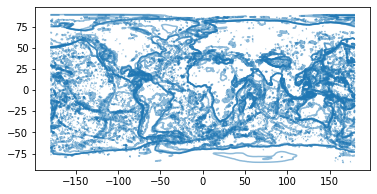

In [5]:
df.sample(10000).plot(alpha=0.5)

In [6]:
# helper function
def segmentize(line):
    return list(map(LineString, zip(line.coords[:-1], line.coords[1:])))

df['geom'] = df.geometry.apply(lambda geom: segmentize(geom))
df = df.explode("geom").reset_index(drop=True)
df = df.rename(columns={'geometry':'_','geom': 'geometry'}).drop(['_'], axis=1)
df

,ID,z,geometry
0,0,-4200.0,"LINESTRING (-130.95778 90.00000, -130.95778 89..."
1,0,-4200.0,"LINESTRING (-130.95778 89.87500, -130.87500 89..."
2,0,-4200.0,"LINESTRING (-130.87500 89.87495, -130.62500 89..."
3,0,-4200.0,"LINESTRING (-130.62500 89.87478, -130.37500 89..."
4,0,-4200.0,"LINESTRING (-130.37500 89.87457, -130.12500 89..."
...,...,...,...
1351009,56143,2800.0,"LINESTRING (178.87500 -86.21200, 179.12500 -86..."
1351010,56143,2800.0,"LINESTRING (179.12500 -86.21984, 179.37500 -86..."
1351011,56143,2800.0,"LINESTRING (179.37500 -86.22842, 179.62500 -86..."
1351012,56143,2800.0,"LINESTRING (179.62500 -86.23691, 179.87500 -86..."


In [7]:
# for inverse geodetic calculation
geod = Geodesic.WGS84

def inverse_radian_km(geom):
    # [[lon0, lat0], [lon1, lat1]]
    coords = np.asarray(geom.coords).ravel()
    #g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    g = geod.Inverse(coords[1], coords[0], coords[3], coords[2])
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    return (radian, g['s12']/1000.0)

def angle_radian(geom):
    return inverse_radian_km(geom)[0]

def length_km(geom):
    return inverse_radian_km(geom)[1]

df['angle'] = df.geometry.apply(angle_radian)
df['length'] = df.geometry.apply(length_km)

In [8]:
# symmetrize directions
_df = df.copy()
_df['angle'] = df.angle.apply(lambda radian: radian-np.pi if radian>=0 else np.pi+radian)
df_sym = pd.concat([df, _df])

## Rose Diagram
https://matplotlib.org/1.2.1/examples/pylab_examples/polar_bar.html

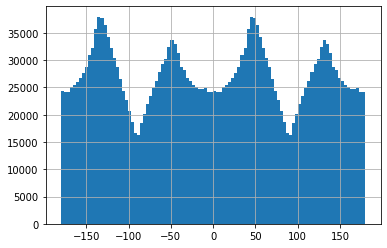

In [9]:
# make the same histogram plot as the rose diagram below
(180*df_sym['angle']/np.pi).hist(bins=100)
plt.show()

In [10]:
# Pandas 0.25.0+
angles = np.linspace(-np.pi, np.pi, 128+1, endpoint=True)
labels = (angles[1:] + angles[:-1])/2
df_sym['sector'] = labels[np.digitize(df_sym.angle, angles)-1]
df_sym_sector = df_sym.groupby(['sector']).agg(num = ('sector','count'),length = ('length','sum')).reset_index()

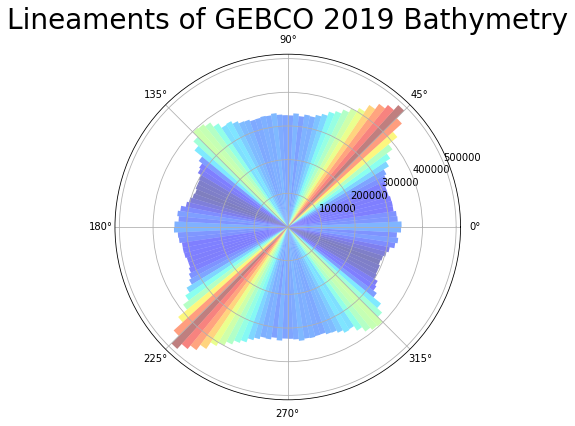

In [11]:
# force square figure and square axes looks better for polar, IMO
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = df_sym_sector.sector.values
radii = df_sym_sector.length.values
width = np.diff(angles)[0]

bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
    bar.set_alpha(0.5)

plt.title(f'Lineaments of GEBCO 2019 Bathymetry', fontsize=28)
plt.savefig(f'IsoLineaments of GEBCO 2019 Bathymetry.jpg', \
            bbox_inches='tight', dpi=150, pil_kwargs={'quality': 95})
plt.show()